Fig 1 supplement 1, script to look at novel partners per each FeCO neuron

In [1]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
from my_functions import *
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.patches as mpatches
import gspread
from collections import Counter
import math
import sys
from functools import reduce
import itertools

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
    
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

fig_path = 'C:/Users/swetarr/Documents/GitHub/feco-connectomics-analysis/figures/'
csv_path = 'C:/Users/swetarr/Documents/GitHub/feco-connectomics-analysis/csv/'

pd.set_option('display.max_rows', 400)
# 'C:/Users/swetarr/Documents/GitHub/connectomics-analysis/csv/'

import time
timestr = time.strftime("%Y%m%d")

In [2]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list
FeCO_df= client.materialize.query_table('feco_axons_v0')
FeCO_df = FeCO_df[FeCO_df['classification_system'].str.contains('T1L')]
allFeCO_ids = FeCO_df['pt_root_id'].to_list()
allFeCO_types = FeCO_df['cell_type'].to_list()

FeCO_dict = dict(zip(allFeCO_ids,allFeCO_types))

syn_threshold = 3; 

In [3]:
#all FeCO neurons
outputs = client.materialize.synapse_query(pre_ids = allFeCO_ids)

####if we are filtering based on somas:
soma_df= client.materialize.query_table('somas_dec2022')
soma_ids = soma_df['pt_root_id'].to_list()
outputs = outputs[outputs['post_pt_root_id'].isin(soma_ids)]
#####

syn_per_allFeCOout = outputs.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_allFeCOout = syn_per_allFeCOout[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_allFeCOout['number_of_synapses'] > syn_threshold]

#how many combinations are we going to go through?
if math.factorial(len(allFeCO_ids)) >= 50:
    n_samples = 50
else:
    n_samples = math.factorial(len(allFeCO_ids))
    

novel_allFeCOouts = np.zeros((n_samples, len(allFeCO_ids)))
for i in range(n_samples):
    this_combo = np.random.permutation(allFeCO_ids)
        
    for j, allFeCO_id in enumerate(this_combo):
        partners = list(set(syn_per_allFeCOout[syn_per_allFeCOout['pre_pt_root_id']==allFeCO_id]['post_pt_root_id'].tolist()))
        if j == 0:
            novel_allFeCOouts[i, j]=len(partners)
            allallFeCOouts = partners
        else:
            allallFeCOouts = list(set(allallFeCOouts + partners))
            novel_allFeCOouts[i, j] = len(allallFeCOouts)
            

meta NOT subset; don't know how to subset; dropped


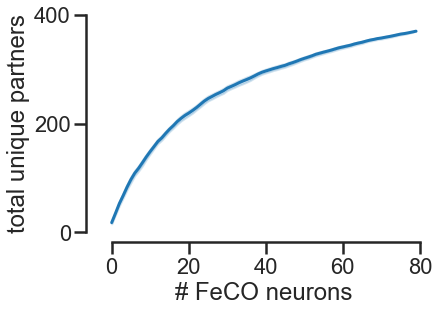

In [4]:
#plot the data

#all FeCO data

#make a master dataframe with all the data
df = pd.DataFrame(novel_allFeCOouts).melt()
# df_wide = df.pivot("variable", "value")

df2 = pd.DataFrame(novel_allFeCOouts, columns=list(range(len(allFeCO_ids))))
df2_transposed = df2.T

sns.set_style("ticks")
# figure_size = [7, 5]
# fig1 = plt.figure(1, figsize = figure_size)
sns.set_context("poster")
ytick_fontsize = 20
xtick_fontsize = 20


g = sns.lineplot(data=df, x="variable", y="value")
g.set(xlabel='# FeCO neurons')
g.set(ylabel='total unique partners')
g.set(ylim=(0, 400), yticks=[0, 200, 400])
# g.set(xlim=(0, 34), xticks=[0, 17, 34])
# g.set_xticklabels(['1','18','35'])
sns.despine(trim=True, offset=10)


# plt.show()

# fig2 = sns.lineplot(data=df2_transposed, legend = False)
# plt.show()
# 
# g.figure.savefig(fig_path+'novelpartners_allFeCO.pdf', dpi = 300, bbox_inches = 'tight')